In [50]:
import numpy as np;
from numpy.linalg import inv;
from numpy.linalg import det;
import math;

# Will read the file and convert it into two dataset one train data other validate data
def readTrainData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                if(addW0Col):
                    phi_i[0]=1;
                else:# removing id col.
                    phi_i.pop();
                # last row is value of yi                
                y_i=phi_i.pop(len(phi_i)-1); 
                phi.append(phi_i);             
                y.append(y_i);
            row_index+=1;
    return [phi,y];
#End-readTrainData

# Will read the file and convert it into dataset for Testing the Model
def readTestData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:                
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                if(addW0Col):
                    phi_i[0]=1;
                else:# removing id col.
                    phi_i.pop();                
                phi.append(phi_i);                             
            row_index+=1;
    m=len(phi);    
    return phi;
#End-readTrainData



#write-output
def writeTestData(ystar):
    fo = open("output.csv", "w");    
    fo.write("ID,MEDV\n");
    m=len(ystar);
    for i in range(m):
        fo.write(str(i)+","+str(ystar[i])+"\n");
    fo.close();
    pass;

# Return det of matrix
def getDet(A):
    d=det(A);
    if(d<10**-10):
        return 0;
    return d;


#Return RMS: root mean square error
def getRMS(y,yStar):
    m=len(y);
    sigma=0;
    for i in range(m):
        delta=(y[i]-yStar[i]);
        delta=delta*delta;
        sigma=sigma+delta;
    meanSq=sigma/m;   
    rms=math.sqrt(meanSq);
    return rms;
    pass;

#For ploting graph of RMS VS Iteration
def plotGraph(x,y):
    import matplotlib.pyplot as plt;
    plt.plot(x,y)
    plt.ylabel('rms')
    plt.xlabel('iteration');
    plt.show();
    pass;

#Record readings for gradient descent
def writeReadingInFile(filename,alpha,lam,iteration,rms,p):
    import os.path;
    import datetime;
    import time;
    ts = datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m-%Y %H:%M:%S')
    if(os.path.exists(filename)==False):
        fo = open(filename, "w"); 
        fo.write("iteration,norm,alpha,lam,rms,timestamp\n");
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    else:
        fo = open(filename, "a"); 
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    fo.close();                    
    pass;


#normalize the data set ny (x-u)/s where s is max-min
def normalizePhi(unNormalizedPhi):    
    phi=np.array(unNormalizedPhi);
    print("Normalizing Phi...");  
    std=phi.std(0);
    mean=phi.mean(0); 
    if(addW0Col):#making first col. mean as 0              
        std[0]=1;
        mean[0]=0;
    phi_normalize=(phi-mean)/std;    
    print("Normalization done.");
    return phi_normalize;
    pass;

#pridict of y* given w* QW=y*
def pridict(dataset,weight):
    phi=np.array(dataset);
    w=np.array(weight);
    ystar=np.dot(phi,w);
    return ystar;
    pass;

# Finding w*=(QTQ)^-1QTY
def trainUsingClosedFormEquation(dataset,output):
    m=len(dataset);
    n=len(dataset[0]);
    print("------------------");
    #print(dataset);
    phi=np.array(dataset);
    print("------------------");
    #print(phi);    
    y=np.array(output);
    phiT=np.transpose(phi);
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi);   
    d=getDet(phiT_phi)
    if(d>0):
        #(QTQ)^-1
        phiT_phi_inv=inv(phiT_phi);
        #(QTQ)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);
        return w;
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;



def numpiTestFun():
    A2= np.matrix([[4,6],[2,8]])        
    A3= np.matrix([[1,2,3],[4,5,7],[7,8,9]])
    A=A2;
    print(A);
    print(np.power(A,0.5));
    print(A);
    print("Det(A):"+str(getDet(A)));
    B= np.transpose(A);
    C=inv(A);
    #print(C);
    print(np.dot(A,C));
    print(A.std(0));
    print(A.mean(0));
    print(normalizePhi(A));
    norm=(A-A.mean(0))/A.std(0);    
    print(norm);    
    print();
    pass;


# Finding w*=(QTQ+lamI)^-1QTY
def trainUsingClosedFormRidgeEq(dataset,output):
    #-------------------------------------
    # Best value: m=300 validate=120
    # addW0=True: c=0.376654. Not lamd
    #-------------------------------------
    m=len(dataset);
    n=len(dataset[0]);    
    phi=np.array(dataset);
    y=np.array(output);
    phiT=np.transpose(phi);    
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi);
    n=len(phiT_phi);
    lam=0.5;
    c=.376654;
    I=np.identity(n);
    lamI=lam*I;
    d=getDet(phiT_phi)
    #--------------------------------------
    if(d>0):
        #(QTQ+lamI)^-1
        phiT_phi_inv=inv((phiT_phi+c));
        #(QTQ+lamI)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ+lamI)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);
        return w;
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;

In [ ]:
# GD: Least Sq. Without Regularlization
def gardientDescentErrorFun(phi,y):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.22;# learning parameter
    maxIteration=10000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    xaxis=list();
    yaxis=list();
    #----------------------
    print("Training Started (Least Sq. Without Regularlization) ...");
    for i in range(maxIteration):  
        wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)));                
        ystar=pridict(phi,wk1);
        rms=getRMS(y,ystar);    
        xaxis.append(i);
        yaxis.append(rms);
        percentComplete=((i+1)*100)/maxIteration;
        if( percentComplete%10==0 ):
            print("Percent Completed",percentComplete);
        wk0=wk1;
    print("Final Trained RMS:",rms);
    plotGraph(xaxis,yaxis);
    return wk1;
    pass;

# GD: Least Sq. With ||w||_(1.5)^(1.5)
def gardientDescentWithPnom(phi,y,p):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.2 #learning parameter
    maxIteration=100000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector    
    wk0=phi[1];
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    lam=0.31;
    xaxis=list();
    yaxis=list();
    algFixedIteration=False;
    logReading=True;
    diff=0;
    wPow=p-1;
    if (p<=1):
        print("Error: norm p is less than 1 i.p p=",wPow);
        return None;
        
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    if (algFixedIteration):
        for iteration in range(0,maxIteration):
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow))); 
            
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if( percentComplete%10==0 ):
                print("Percent Completed",percentComplete);
            wk0=wk1;
    else:
        diffOffset=1e-20;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):            
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow)));  
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=abs(oldRms-rms);
            
            vystar=pridict(validateDatasetPhi,wk1);
            vrms=getRMS(validateDatasetY,vystar);
            vdiff=voldRms-vrms;
            
            if(iteration>0 and  diff<=diffOffset):
                break;
            if(False and iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);            
            wk0=wk1;
            oldRms=rms;
            voldRms=vrms;
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);    

    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);       
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("pnom.csv",alpha,lam,iteration,rms,p);
    plotGraph(xaxis,yaxis);
    return wk1; 

#wStart=gardientDescentWithRidge(trainDatasetPhi,trainDatasetY);
#wStart=gardientDescentWithPnom(trainDatasetPhi,trainDatasetY,4);
#mainRidgeClosedFormSol();


Fetching Trained Dataset from file...
Normalizing Phi...
Normalization done.
Normalizing Phi...
Normalization done.
Fetching of data Completed.
Train Size:300
Validate Size:120
Training Started (Least Sq. With Ridge) ...
Percent Completed 10.0 rms: 4.058886855464154
Percent Completed 20.0 rms: 3.9613314063836293
Percent Completed 30.0 rms: 3.9453286752248657
Percent Completed 40.0 rms: 3.9420473286970528
Percent Completed 50.0 rms: 3.9412061910866654
Percent Completed 60.0 rms: 3.9409447595290374
Percent Completed 70.0 rms: 3.9408529341384337
Percent Completed 80.0 rms: 3.9408186232202644
Percent Completed 90.0 rms: 3.9408054412713946
Percent Completed 100.0 rms: 3.9408003156320706
Final Trained RMS: 3.9408003156320706 . Iteration needed  999999


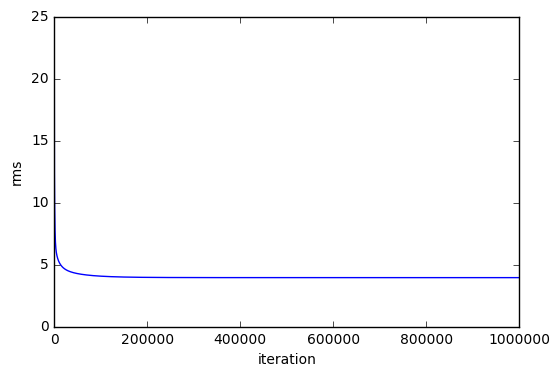

Gradient Desent ||Norm||=2 RMS: 4.449621281343252


In [111]:

def mainClosedFormSol(dataset):
    
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormEquation(tdsPhi,tdsY);
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Closed Form Solution RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;


def mainRidgeClosedFormSol(dataset):
    #-------------------------------------
    # Best value: m=300 validate=120
    #-------------------------------------    
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormRidgeEq(tdsPhi,tdsY);
    print(wStar);
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Closed FormSol With Ridge RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;

def mainGradientDesent(dataset):
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Gradient decent without Regularlization]--------------------------------
    wStar=gardientDescentWithRidge(tdsPhi,tdsY);
    #wStar=gardientDescentWithPnom(trainDatasetPhi,trainDatasetY,(4/3));
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Gradient Desent ||Norm||=2 RMS:",rms);
    #---------------------------------------------------------------------------------------------

    
#split train data into Train and Validate
def spitTrainDataset(phi,y):
    m=len(phi);        
    tdsSize=int(m*trainDSSizePercentage);
    l=300;
    trainDatasetPhi=phi[0:l];
    trainDatasetY=y[0:l];
    validateDatasetPhi=phi[tdsSize:m];
    validateDatasetY=y[tdsSize:m];    
   
    return [trainDatasetPhi,trainDatasetY,validateDatasetPhi,validateDatasetY];    
    pass

def createNewFeatureMatrix(phi,maxDeg=4):    
    newPhi=np.array(phi);
    p=np.array(phi);        
    if(addW0Col):#deleting first W0Col coffecient is 1
        p=np.delete(p,0,1);    
    i=2;
    while(i<=maxDeg):
        pPowI=np.power(p,i);        
        newPhi=np.concatenate((newPhi,pPowI),axis=1);
        i+=1;
    return newPhi;
    pass;

# GD: Least Sq. With Ridges
def gardientDescentWithRidge(phi,y,wi=-1):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.0003;# learning parameter
    maxIteration=1000000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    if(wi==-1):
        wk0=np.zeros(n);# Nx1 vector
    else:
        wk0=phi[wi]
    
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    lam=0.301;    
    xaxis=list();
    yaxis=list();
    algFixedIteration=True;
    logReading=True;
    diff=0;
    #-----------------------------------------------------------------
    #Best Tested Constant
    #1)With 13 features i.e original Phi
    #normalize phi: true.
    #aplha=.212 lamda=.301 tds=300 vds=120 Iteo/p=4.8310 rms
    #Note: Tried for different initial wk0 from phi matrix but o/p remain same
    #
    #2)With 26 features i.e newphi=phi + phi^2
    #normalize phi: true; algFixedIteration=True; maxIteration=1000000;
    #aplha=.0003 lamda=.301 tds=300 vds=120 o/p=3.940800315632070 rms
    #Tried for different initial wk0 but o/p remain same
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    if (algFixedIteration):
        for iteration in range(0,maxIteration):  
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));              
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if( percentComplete%10==0 ):
                print("Percent Completed",percentComplete,"rms:",rms);                
            wk0=wk1;
    else:
        diffOffset=1e-20;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));                     
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=abs(oldRms-rms);            
            if(iteration>0 and diff<diffOffset):
                break;
            if(iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff);            
            wk0=wk1;
            oldRms=rms;
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff);    
           
    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);    
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("ridge1.csv",alpha,lam,iteration,rms,2);
    plotGraph(xaxis,yaxis);
    return wk1;



#--settings--
np.set_printoptions(suppress=True)
#---init---
dir=""
trainFile=dir+"train.csv";
testFile=dir+"test.csv";
trainDSSizePercentage=0.7; # x*100 percentage. 1-x data set will be used for validating
addW0Col=True;
#---------------------------------------------
print("Fetching Trained Dataset from file...");
dataset=readTrainData(trainFile);
testDS=readTestData(testFile);
phiSet=dataset[0];
ySet=dataset[1];
phiSet_norm=normalizePhi(phiSet);
testDS_norm=normalizePhi(testDS);
tds=spitTrainDataset(phiSet,ySet);
tds_norm=spitTrainDataset(phiSet_norm,ySet);

print("Fetching of data Completed.");

#train set
trainDatasetPhi=tds[0];
trainDatasetY=tds[1];
validateDatasetPhi=tds[2];
validateDatasetY=tds[3];

trainDatasetPhi_norm=tds_norm[0];
trainDatasetY_norm=tds_norm[1];
validateDatasetPhi_norm=tds_norm[2];
validateDatasetY_norm=tds_norm[3];

deg=2;
trainDatasetPhi_norm=createNewFeatureMatrix(trainDatasetPhi_norm,deg);
validateDatasetPhi_norm=createNewFeatureMatrix(validateDatasetPhi_norm,deg);
testDS_norm=createNewFeatureMatrix(testDS_norm,deg);

print("Train Size:"+str(len(trainDatasetPhi)));
print("Validate Size:"+str(len(validateDatasetPhi)));

ds=[trainDatasetPhi,trainDatasetY,validateDatasetPhi,validateDatasetY,testDS];
ds_norm=[trainDatasetPhi_norm,trainDatasetY,validateDatasetPhi_norm,validateDatasetY,testDS_norm];
#mainClosedFormSol(ds);
#mainRidgeClosedFormSol(ds_norm);
mainGradientDesent(ds_norm);


